# Natural Language Processing Task

## Overview

* [Task 1: Problem Statement](#task-1-problem-statement)

    * [Step 1: Preprocessing](#step-1-preprocessing)  

        * [Document Segmentation](#document-segmentation) 
        
        * [Text Normalization](#text-normalization)
    
    * [Step 2: Context Identification](#step-2-context-identification)

        * [Contextual Analysis](#contextual-analysis)

            * [Term Frequency-Inverse Document Frequency (TF-IDF)](#term-frequency-inverse-document-frequency)

            * [Non-negative Matrix Factorization (NMF)](#non-negative-matrix-factorization)

        * [Identifying Relevant Tokens](#identifying-relevant-tokens)

    * [Step 3: Tokenization](#step-3-tokenization)

        * [Choose a Tokenization Approach](#choose-a-tokenization-approach)

    * [Step 4: Counting and Output](#step-4-counting-and-output)

        * [Keyword Matching and Document-Level Count](#keyword-matching-and-document-level-count)

        * [Aggregate and Print](#aggregate-and-print)

    * [Step 5: Putting It All Together](#step-5-putting-it-all-together)
    
    * [Finally: Challenges and Considerations](#finally-challenges-and-considerations)

* [Task 2: Problem Statement](#task-2-problem-statement)

    * [Step 1: Data Preparation](#step-1-data-preparation)

        * [Load the Datasets](#load-the-datasets)

        * [Perform Embeddings](#perform-embeddings)

    * [Step 2: Visualize Embeddings](#step-2-visualize-embeddings)

        * [Dimensionality Reduction](#dimensionality-reduction)

        * [Clustering with K-Means](#clustering-with-k-means)

            * [Elbow method](#elbow-method)

            * [Silhouette method](#silhouette-method)
        
        * [Conclusion on Explanatory Data Analysis (EDA)](#conclusion-on-explanatory-data-analysis-eda)
        
    * [Step 3: Sentiment Analysis Model Selection](#step-3-sentiment-analysis-model-selection)

    * [Finally: Challenges and Considerations](#finally-challenges-and-considerations-2)

# Task 1: Problem Statement <a id="task-1-problem-statement"></a>

Identify tokens that refer to <u>**gold**</u> and <u>**silver**</u> (with separate identifiers for each) as financial commodities. Print out the number of documents in the sample file containing at least one reference to gold and the same for silver.

## Step 1: Preprocessing <a id="step-1-preprocessing"></a>

### Document Segmentation <a id="document-segmentation"></a>

Text data can contain multiple documents and it is crucial to segment these documents effectively. This could be based on specific delimiters or patterns that denote the beginning or end of a document.

On first glance, the text file seems to contain tweets and articles as documents that were scrapped from the internet. While it seems that many of these documents are delimited by break lines (i.e. `"\n"`), this might not be the case throughout the text data. Break lines could also exist between sentences of articles as well which makes this preprocessing step tricky.

Nonetheless, for our purposes, splitting the text data into documents by break lines should suffice.

In [1]:
docs = []

with open("data/sample.txt", "r") as f:
    for line in f:  # read the text line by line
        if line != "\n":  # remove the lone break lines
            docs.append(line)


print(f"Number of documents: {len(docs)}")

Number of documents: 1554


### Text Normalization <a id="text-normalization"></a>

Next, we have to convert the text to a uniform case (usually lowercase) to ensure that tokens are matched effectively, irrespective of their case in the text. Additionally, we should remove any irrelevant characters or symbols that may not contribute to understanding the context of gold and silver as commodities. 

Many tweets contain irrelevant terms like the usernames of users (i.e. `@john_doe`). We should remove these. Many tweets and articles also contain links to other websites. I would consider these as noise and propose to remove these as well. 

**Note:** Another thing we could consider removing are emojis. However, this is debatable depending on your methodology. For example, emojis could prove to be important in downstream tasks like sentiment analysis when you generate embeddings over the sentences. Clustering on these embeddings could also reveal underlying latent structure in our text data. 

In [2]:
import re

from tqdm import tqdm


def remove_tags(text: str) -> str:
    """
    If there's a tag present, replace with a whitespace.
    Also convert all text into lowercase.

    Args:
        text (str): The text to clean.

    Returns:
        str: The cleaned text with tags replaced.
    """
    new_text = re.sub(r"@\w+", "", text).strip()
    return new_text.lower()


def remove_url(text: str) -> str:
    """
    If there's a URL present, replace with a whitespace.
    Also convert all text into lowercase.

    Args:
        text (str): The text to clean.

    Returns:
        str: The cleaned text with URL replaced.
    """
    new_text = re.sub(
        r"(http[s]?:\/\/)?[a-zA-Z0-9]{1,}\.[a-zA-Z0-9]+[\.a-zA-Z0-9]+[\/a-zA-Z0-9]*",
        "",
        text,
    ).strip()
    return new_text.lower()

In [3]:
cleaned_docs = []

with open("data/cleaned.txt", "w") as f:
    for d in tqdm(docs):
        d = remove_tags(d)
        d = remove_url(d)
        cleaned_docs.append(d)
        f.write(d + "\n")


# Print first 5 documents
for d in cleaned_docs[:5]:
    print()
    print(d, end="\n\n")

100%|██████████| 1554/1554 [00:00<00:00, 23028.69it/s]


gold the tenrec


tokyo-bound sampson sets aust rifle record. shooter dane sampson has struck career-best form as he builds towards a third olympics, setting a national record while winning the 50m rifle event at the south australia championships. sampson registered a score of 462 points to claim gold in the three positions event. the performance bettered sampson's own national record of 460.7 points, which he achieved at last month's wingfield grand prix. the score was also notably higher than what italy's niccolo campriani (458.8) and poland's tomasz bartnik (460.4) produced to win gold at the 2016 olympics and 2018 world championships respectively. "it's good to be shooting pbs at this stage. it was a world-class finals score," sampson said, having previously competed at the 2012 and 2016 olympics. "you are unlikely to lose many competitions with that score. "i definitely feel that i am getting better and better and i am tracking well for tokyo." sampson and other members of austra

## Step 2: Context Identification <a id="step-2-context-identification"></a>

### Contextual Analysis <a id="contextual-analysis"></a>

Just finding the words "gold" and "silver" may not be enough as they could be used in different contexts. To ensure you’re identifying them as commodities, you may need to analyze the context in which they’re used. For example, if "gold" or "silver" is used in the same sentence as words like "market", "price", "trade", "ounce", etc., it’s likely being used as a commodity.

In this section, I would like to attempt a well-known unsupervised technique called topic modeling. In topic modelling, there are two main techniques:

1. Latent Dirichlet Allocation (LDA) 
2. Non-negative Matrix Factorization (NMF)

Below, we define a plotting function that visualizes the top `n_top_words` words from an arbitrary number of topics (`n_components`). Here, we will set 
`n_top_words=20` and `n_components=10`. We will also set an embedding size or number of features to 1024. Feel free to play around with these values.

In [4]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer


n_samples = len(cleaned_docs)  # total number of documents
n_features = 1024  # embedding size
n_components = 10  # number of topics (an arbitrary value so feel free to experiment)
n_top_words = 20  # top words for each topic ot visualize
random_state = 42  # for reproducibility
init = "nndsvda"  # Nonnegative Double Singular Value Decomposition (NNDSVD) initialization with zeros filled with the average of X (better when sparsity is not desired)


def plot_top_words(model: NMF, feature_names: np.ndarray, n_top_words: int, title: str):
    """
    Plots top `n_top_words` for each topic.

    Args:
        model (NMF): The Non-negative matrix factorization model.
        feature_names (np.ndarray): The feature names.
        n_top_words (int): The top words to plot.
        title (str): Title for the plot.
    """
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(
        model.components_
    ):  # shape: (n_components, n_features) -> (10, 1024)
        top_features_ind = topic.argsort()[
            -n_top_words:
        ]  # note: .argsort sorts in ascending order
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.tight_layout()
    plt.show()

#### Term Frequency-Inverse Document Frequency (TF-IDF) <a id="term-frequency-inverse-document-frequency"></a>

NMF works on a matrix of normalized word-document counts. More specifically, we have to convert our list of documents into features. We can do so using Term Frequency-Inverse Document Frequency (TF-IDF).

To calculate the TF-IDF value of a word, we first count the frequency of the word in a particular document (term frequency), and then divide the total number of documents by the count of documents that also contain that word. We then take the product of the term frequency and $log$ of the latter term to get the TF-IDF value. THe $log$ of the latter term is also known as the inverse document frequency. 

Mathematically speaking, TF-IDF is defined as:

$$
TF(t, d) = \frac{\text{number of times } t \text{ appears in document } d}{\text{total number of terms in document }d}
\\[10pt]
IDF(t) = \log{\frac{N}{1 + df}}
\\[10pt]
TF-IDF(t, d) = TF(t, d) \times IDF(t)
$$

In [5]:
# Use TF-IDF features for NMF
print("Extracting TF-IDF features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95,  #  if term occurs in more than 95% of all documents, we ignore
    min_df=2,  # if term occurs in less than 2 documents, we ignore
    ngram_range=(
        2,
        3,
    ),  # I chose to consider bigrams and trigrams to capture some semantics
    max_features=n_features,  # aka the embedding size
    stop_words="english",  #
)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(
    cleaned_docs
)  # shape: (n_samples, n_features) where n_samples are the no. of documents -> (1554, 1024)
print("Done in %0.3fs." % (time() - t0))

Extracting TF-IDF features for NMF...
Done in 0.375s.


#### Non-negative Matrix Factorization (NMF) <a id="non-negative-matrix-factorization"></a>

NMF decomposes a non-negative matrix into two non-negative matrices: 

1. $\mathbf{W}$ where each row is a document and each column is a topic and
2. $\mathbf{H}$ where each row is topic and each column is a term.

Therefore, NMF assumes that each document is a linear combination of the topics and each topic is a linear combination of the terms. NMF works best with shorter texts such as tweets and does well to identify incoherent topics. Looking at how our data has lots of tweets (which can be both short and incoherent compared to articles), it makes sense to adopt NMF for topic modelling here.

To further illustrate this point, we can see that 90% of documents have word counts that are below the cutoff of 167 words in the plot below.

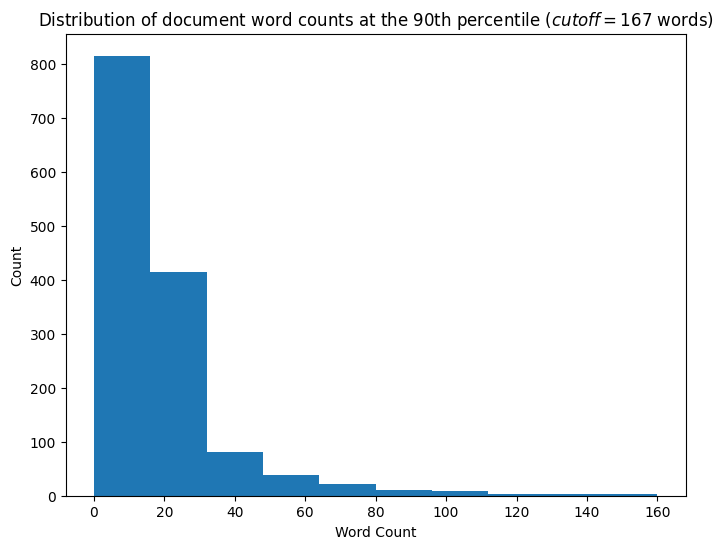

In [6]:
q = 90  # percentile cutoff
doc_lengths = np.asarray(
    [len(d.split()) for d in cleaned_docs]
)  # get word counts for all documents
cutoff = np.percentile(
    doc_lengths, q=q
)  # get word count cutoff where the 90th percentile is
doc_lengths_below_cutoff = doc_lengths[doc_lengths <= cutoff]  # filter

plt.figure(figsize=(8, 6))
plt.title(
    f"Distribution of document word counts at the {q}th percentile ($cutoff={int(cutoff)}$ words)"
)
plt.hist(doc_lengths_below_cutoff)
plt.xlabel("Word Count")
plt.ylabel("Count")
plt.show()

In NMF, we chose the optimization objective to be the minimization of the Frobenius norm. Where the squared difference of the reconstructed matrix, $\mathbf{W}\cdot\mathbf{H}$ and the original matrix $\mathbf{A}$ is minimized.

In [7]:
# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) "
    "with TF-IDF features, n_samples=%d and n_features=%d..." % (n_samples, n_features),
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=random_state,
    init=init,
    beta_loss="frobenius",  # similar to L2 norm but instead of vectors, Frobenius norm is for matrices
    solver="mu",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

Fitting the NMF model (Frobenius norm) with TF-IDF features, n_samples=1554 and n_features=1024...
done in 0.254s.


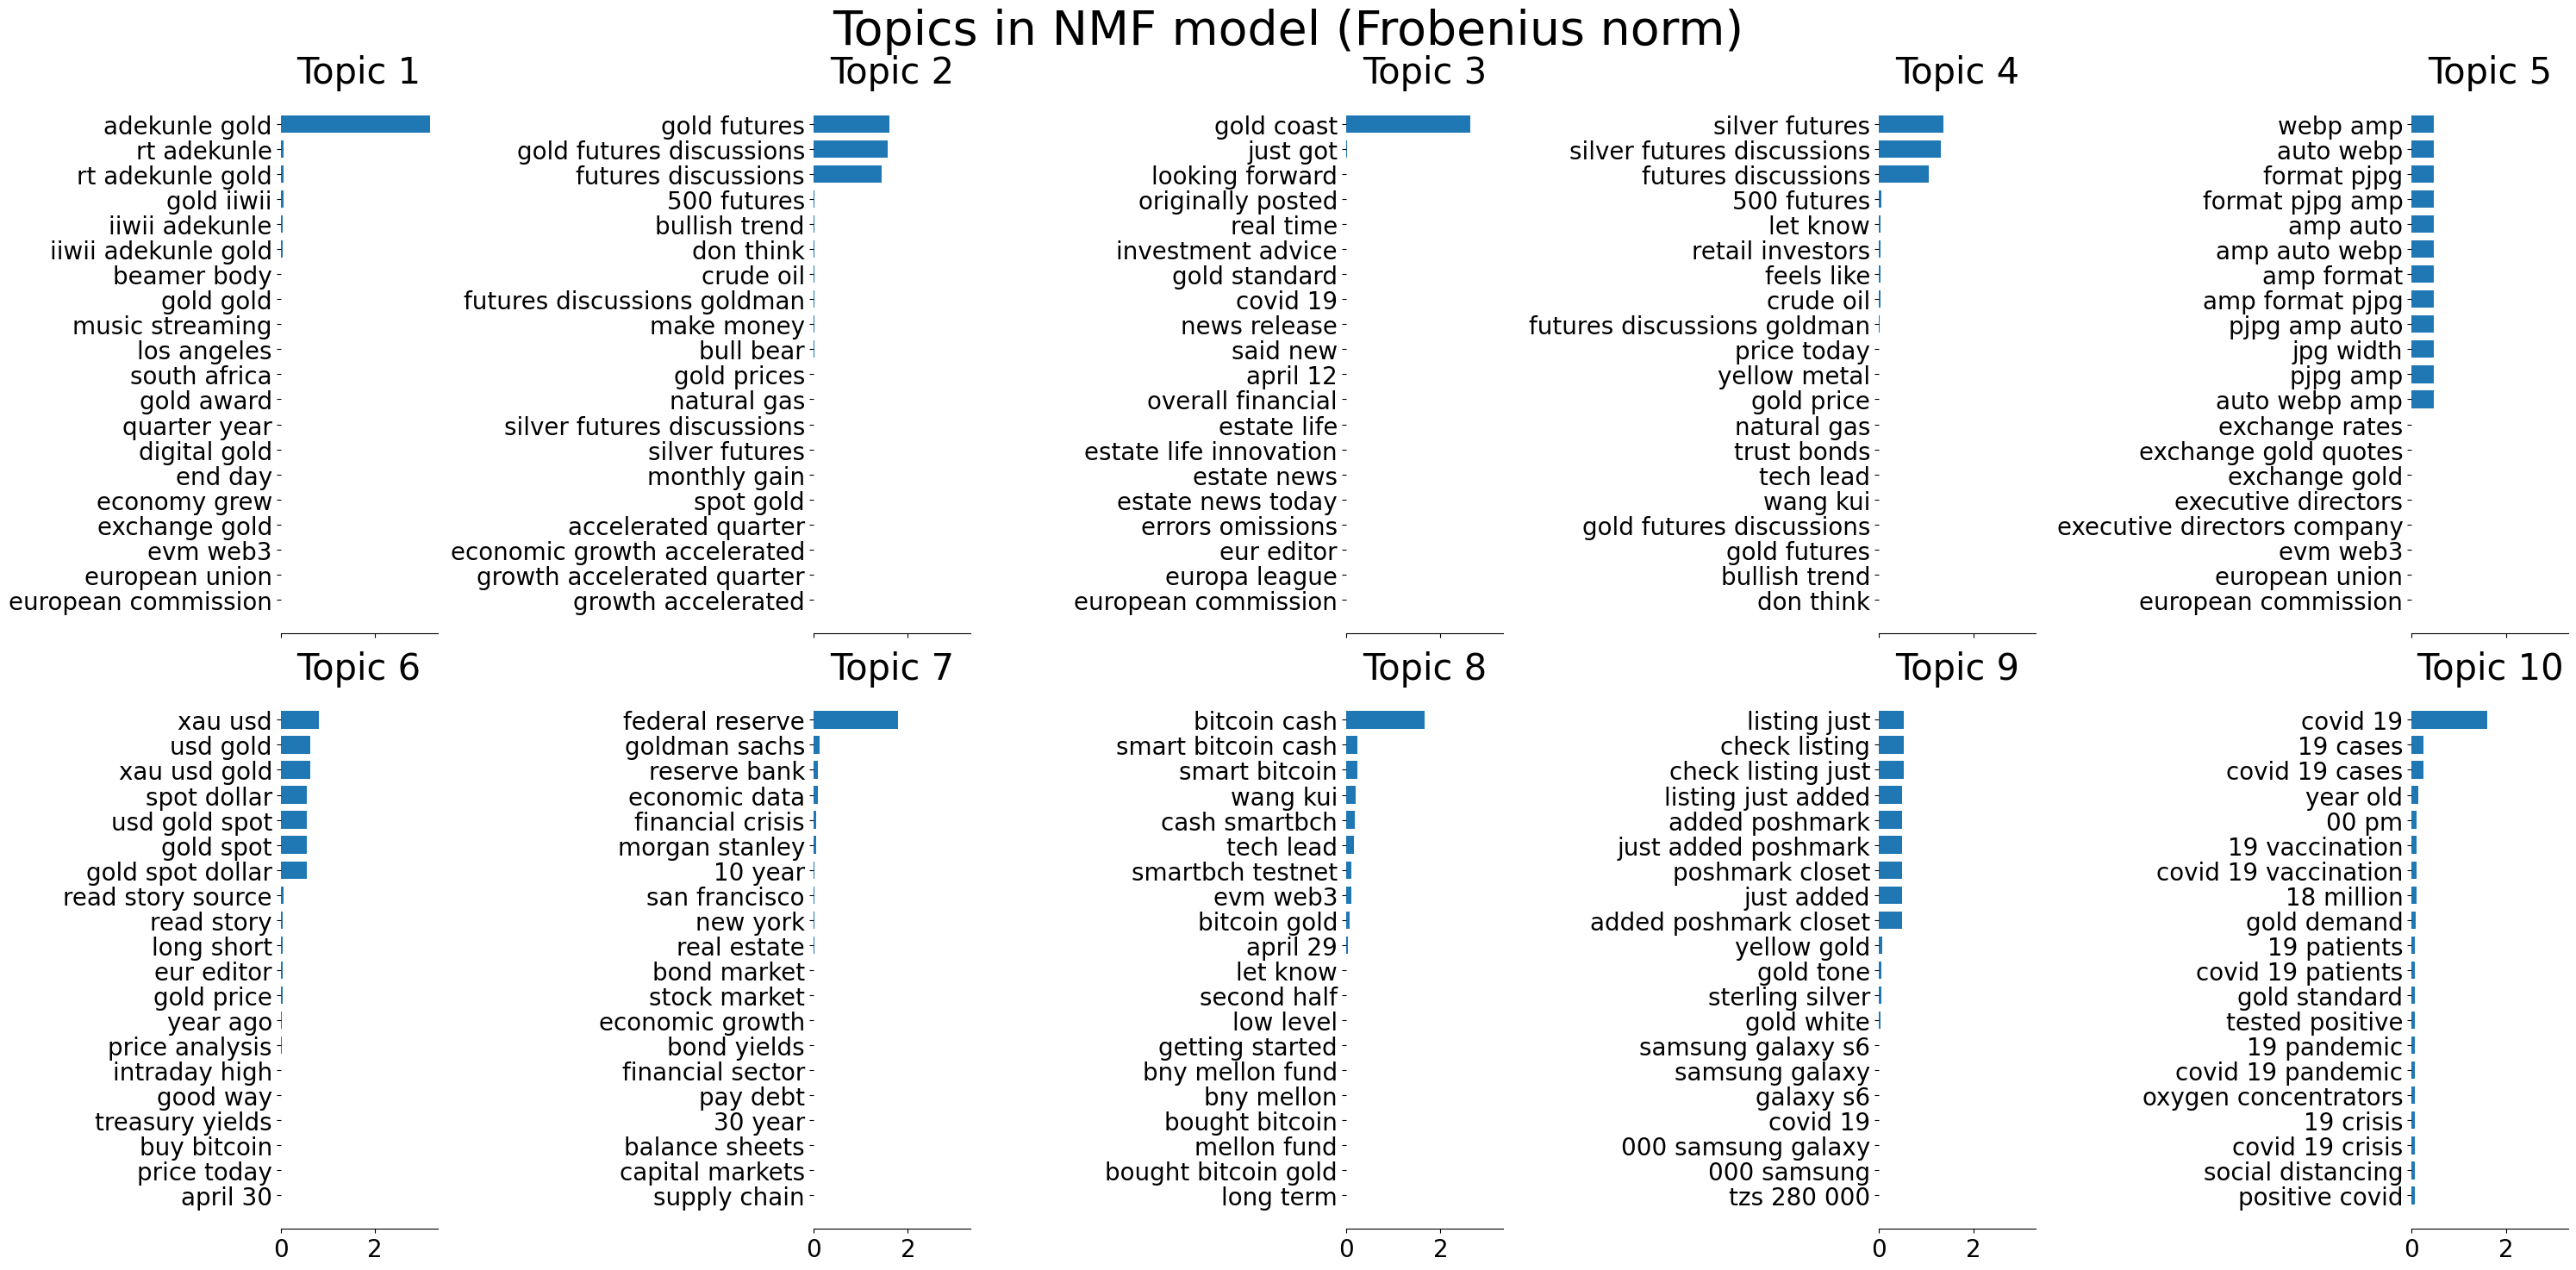

In [8]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (Frobenius norm)",
)

### Identifying Relevant Tokens <a id="identifying-relevant-tokens"></a>

Now that we have carried out NMF on our processed data, it is easy to identify the tokens that refer specifically to gold and silver as commodities. From the image above, we can see that the tokens related to "gold" or "silver" as a commodity include, but are not limited to; 

- _Gold/Silver futures_,
- _Bullish trend_,
- _Yellow metal/gold_,
- _Sterling silver_,
- _XAU/USD_, (we should also consider XAG/USD for silver)
- _Gold Spot US Dollar_,
- _BNY Mellon Fund_ and
- _Digital gold_ (open to intepretation)


**Note:** It is interesting to note that NMF was able to cluster tokens related to Adenkule Gold into the same topic. A simple google search shows that he is a [Nigerian singer-songwriter](https://www.google.com/search?q=adekunle+gold&rlz=1C5GCCM_en&oq=ad&gs_lcrp=EgZjaHJvbWUqBggCEEUYOzIGCAAQRRg5MgYIARBFGDsyBggCEEUYOzIGCAMQRRg7MhAIBBAuGMcBGLEDGNEDGIAEMgYIBRBFGDwyBggGEEUYPTIGCAcQRRg80gEIMzM2MmowajeoAgCwAgA&sourceid=chrome&ie=UTF-8). We can further confirm from the other tokens in the same topic (see _Topic 1_). More specifically, we see the tokens _"music streaming"_ and _"gold award"_ which further indicates that the "gold" in "Adenkule Gold" is not the commodity "gold" we want to consider in this task.


In [9]:
keywords = [
    "futures",
    "prices",
    "bullish",
    "trend",
    "yellow",
    "metal",
    "sterling",
    "xau/usd",
    "xag/usd",
    "spot",
    "us dollar",
    "bny mellon fund",
    "digital",
]

## Step 3: Tokenization <a id="step-3-tokenization"></a>

### Choose a Tokenization Approach <a id="choose-a-tokenization-approach"></a>

We can use space-based tokenization, regular expressions, or more sophisticated methods like the ones available in NLP libraries (e.g., NLTK, spaCy). The choice depends on the complexity of the text and the need for accuracy in token detection. In this task, we will use a simple space-based tokenization because I would like to see if a relevant token exists which we have identified [above](#identifying-relevant-tokens).

In [10]:
from nltk.tokenize import word_tokenize


def tokenize_text(text: str) -> list[str]:
    """
    Tokenize the text into a list of words that makes up the text.

    Args:
        text (str): The text to tokenize.

    Returns:
        list[str]: The tokenized text.
    """
    # Tokenization
    tokens = word_tokenize(text)
    return tokens

In [11]:
# Example usage
idx = 0

text = cleaned_docs[idx]
tokens = tokenize_text(text)


print(f"Text: {text}")
print(f"Tokenized: {tokens}")

Text: gold the tenrec
Tokenized: ['gold', 'the', 'tenrec']


## Step 4: Counting and Output <a id="step-4-counting-and-output"></a>

### Keyword Matching and Document-Level Count <a id="keyword-matching-and-document-level-count"></a>

Directly matching tokens to a predefined list of keywords related to gold and/or silver. For each document, maintain a count of unique references to “gold” and “silver” in the financial context. This means if “gold” is mentioned five times in the same context within one document, it still counts as one reference for that document.

We have specified the keywords we are using [above](#identifying-relevant-tokens). For refernce, we will show the keywords right here:

```python
keywords = [
    "futures",
    "prices",
    "bullish",
    "trend",
    "yellow",
    "metal",
    "sterling",
    "xau/usd",
    "xag/usd",
    "spot",
    "us dollar",
    "bny mellon fund",
    "digital",
]
```

**Note:** Financial discourse may change so it is important to keep these keywords updated.

We define a function that will return the number of mentions for "gold" and "silver" in the text corpus.

In [12]:
def identify_commodity_tokens(
    tokens: list[str], keywords: list[str]
) -> tuple[int, int]:
    """
    Returns the number of mentions for "gold" and "silver" in the text corpus.
    This is accomplished by checking each document to see if any of the keywords exist.
    If it exists, check to see if either "gold" and/or "silver" is/are mentioned and increment the count.

    Args:
        tokens (list[str]): A list of words that was tokenized from a text representing a document.
        keywords (list[str]): The keywords that may refer to gold and/or silver as commodity.

    Returns:
        tuple[int, int]: The mentions for "gold" and "silver". 1 is it is mentioned else 0.
    """
    gold_mention, silver_mention = 0, 0

    # Iterate keywords because tokens can be very long
    for kw in keywords:
        # If any of the keywords are in the tokens,
        # we want to check if either "gold" or "silver" is mentioned
        if kw in tokens:
            # Check for "gold" mention
            if "gold" in tokens:
                gold_mention += 1
            # Check for "silver" mention
            if "silver" in tokens:
                silver_mention += 1
        # We don't care if "gold" or "silver" appears more than once in the document
        # If it appears more than once, we only want to count it once
        # Therefore, the mention will always be maximum 1 for both "gold" and "silver" mentions
        break
    return gold_mention, silver_mention

In [13]:
# Example usage
idx = 1001

text = cleaned_docs[idx]
tokens = tokenize_text(text)
gold_mention, silver_mention = identify_commodity_tokens(tokens, keywords)


print(f"Gold commodity mentioned: {gold_mention}")
print(f"Silver commodity mentioned: {silver_mention}")

Gold commodity mentioned: 1
Silver commodity mentioned: 0


### Aggregate and Print <a id="aggregate-and-print"></a>

Now, we will summarize the counts across all documents and print out the number of documents containing at least one reference to gold and the same for silver.

In [14]:
def count_documents_with_mentions(
    documents: list[str], keywords: list[str]
) -> tuple[list[int], int, int]:
    """
    Returns the number of documents with mentions of either gold or silver as
    commodities as well as the indices of the documents.

    Args:
        documents (list[str]): The documents making up the text corpus.
        keywords (list[str]): The keywords that may refer to gold and/or silver as commodity.

    Returns:
        tuple[list[int], int, int]: The counts of documents with gold or silver mentioned as commodities.
                                    If a document mentions both gold and silver, the respective counts will
                                    increment by 1. Also returns the indices of the documents.
    """
    document_indices = set()
    gold_documents, silver_documents = 0, 0

    for i, document in enumerate(documents):
        tokens = tokenize_text(document)
        gold_mention, silver_mention = identify_commodity_tokens(tokens, keywords)

        if gold_mention == 1:
            gold_documents += 1
            document_indices.add(i)
        if silver_mention == 1:
            silver_documents += 1
            document_indices.add(i)

    return list(document_indices), gold_documents, silver_documents

## Step 5: Putting It All Together <a id="step-5-putting-it-all-together"></a>

Let's see how many documents have mentions of gold and silver.

**Note:** It is naive to add documents with gold mentions and documents with silver mentions and assume the total is the number of documents with gold or silver mentions. This is because some documents may have mentions of **both** gold and silver.

In [15]:
document_indices, gold_documents, silver_documents = count_documents_with_mentions(
    cleaned_docs, keywords=keywords
)


print(f"Number of documents mentioning gold: {gold_documents}")
print(f"Number of documents mentioning silver: {silver_documents}")

Number of documents mentioning gold: 64
Number of documents mentioning silver: 27


In [16]:
with open("data/sentiment.txt", "w") as f:
    for i in document_indices:
        d = cleaned_docs[i]
        f.write(str(i) + "\t" + d + "\n")

Let's view some of the documents with gold and/or silver mentions. We'll make use of the `document_indices` which stores the indices of documents with gold and/or silver mentions and write a simple function to highlight the mentions of "gold" and 'silver".

In [17]:
from random import sample


def highlight_mentions(text: str) -> str:
    """
    Highlihgts the mentions of "gold" and "silver" in the text.

    Args:
        text (str): The target text.

    Returns:
        str: The text with highlighted mentions of "gold" and "silver" in the text.
    """
    positions = [(x.start(0), x.end(0)) for x in re.finditer(r"gold|silver", text)]
    num_mentions = len(positions)
    highlighted_text = ""
    for i, pos in enumerate(positions):
        prefix, suffix = "\x1b[1;30;43m", "\033[0m"

        if num_mentions == 1:  # if total number of mentions is more than 1
            highlighted_text += text[: pos[0]]
            highlighted_text += prefix + text[pos[0] : pos[-1]] + suffix
            highlighted_text += text[pos[-1] :]

        # Total number of mentions is more than 1
        elif i == 0:  # if it's the first mention
            highlighted_text += text[: pos[0]]
            highlighted_text += prefix + text[pos[0] : pos[-1]] + suffix
            next_pos = positions[i + 1]
            highlighted_text += text[pos[-1] : next_pos[0]]
        elif i == num_mentions - 1:  # if it's the last mention
            highlighted_text += prefix + text[pos[0] : pos[-1]] + suffix
            highlighted_text += text[pos[-1] :]
        else:
            highlighted_text += prefix + text[pos[0] : pos[-1]] + suffix
            next_pos = positions[i + 1]
            highlighted_text += text[pos[-1] : next_pos[0]]

    return highlighted_text


# sample_indices = sample(document_indices, 5)  # uncomment to sample
sample_indices = [3, 371, 631, 1068, 804]

for i in sample_indices:
    document = cleaned_docs[i]
    print(highlight_mentions(document))
    print()

"us 500 futures discussions. hey guys what is gold's history in may?

silver futures discussions. convey my wishes to short employee for yesterday work

zhongliang holdings (02772) notice of annual general meeting / suspension of registration procedures or change of date of suspension of registration. zhongliang holdings (02772) notice of annual general meeting (339kb, pdf) previous post: today&#39;s hong kong economic journal | today&#39;s hong kong economic journal | today&#39;s economic journal | today&#39;s economic journal | today&#39;s economic journal | dr. yuen kangjue | sino health | wealth management international finance | today 04 :44 important notice | today 08:22 hong kong stocks direct attack | today 10:31 international finance | today 07:59 real estate news | today 09:50 hong kong stocks direct attack | today 13:38 current affairs pulse | today 11:15 current affairs pulse | today 09: 45 hong kong stocks direct attack | today&#39;s 09:28 instant market comment | today&#3

## Finally: Challenges and Considerations <a id="finally-challenges-and-considerations"></a>

* **Ambiguity in Language:** The main challenge is distinguishing mentions of gold and silver in financial terms from other contexts. Attention to context is critical.

* **Polysemy:** Words like “gold” and “silver” can have multiple meanings, necessitating a deeper analysis of sentence structure and neighbouring words. Apart from “gold” and “silver,” identify possible variations and synonyms that could refer to these commodities (e.g., “Au” for gold, “Ag” for silver, possibly including common misspellings or abbreviations).

* **Accuracy vs. Performance:** More sophisticated models provide better accuracy in context identification but might be slower. This is crucial, as “gold” and “silver” can be mentioned in various contexts (e.g., jewelry, medals). Look for nearby words that may indicate a financial context, such as “market,” “price,” “investment,” “commodity,” or related terms.

* **Dynamic Language Use:** Financial discourse may evolve, introducing new synonyms or jargon. Keeping your token list and context identifiers updated is important. For example, Bitcoin is a fairly new term (introduced in 2009) and with it came a slew of new terminologies like "digital gold" etc.

# Task 2: Problem Statement <a id="task-2-problem-statement"></a>

Compute the sentiment of sentences where gold or silver are mentioned as commodities. Print out one overall (full sample file) sentiment value for gold and for silver separately.

## Step 1: Data Preparation <a id="step-1-data-preparation"></a>

In [18]:
import os

import pandas as pd
import tiktoken
from dotenv import load_dotenv
from openai import OpenAI

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

### Load the Datasets <a id="load-the-datasets"></a>

Load the datasets from [Task 1](#task-1-problem-statement). We will create a dataframe where we will store the number of tokens from tokenization using `tiktoken`. It works by performing the BPE algorithm iteratively on the raw text. We will also store the embeddings from OpenAI's embedding model.

In [19]:
docs = []

with open("data/sample.txt", "r") as f:
    for line in f:  # read the text line by line
        if line != "\n":  # remove the lone break lines
            docs.append(line)


cleaned_docs = []

with open("data/cleaned.txt", "r") as f:
    for line in f:  # read the text line by line
        cleaned_docs.append(line)


document_indices, sentiment_docs = [], []

with open("data/sentiment.txt", "r") as f:
    for line in f:  # read the text line by line
        index, document = line.strip().split("\t")
        document_indices.append(index)
        sentiment_docs.append(document)


print(f"Number of documents: {len(docs)}")
print(f"Number of documents (cleaned): {len(cleaned_docs)}")
print(f"Number of documents (sentiments): {len(sentiment_docs)}")

Number of documents: 1554
Number of documents (cleaned): 1554
Number of documents (sentiments): 85


In [20]:
sentiment_df = pd.DataFrame({"index": document_indices, "document": sentiment_docs})
sentiment_df

,index,document
0,3,"""us 500 futures discussions. hey guys what is ..."
1,1029,jd ubs yijia niu o (52617) bonds and structure...
2,9,"gold futures discussions. so, any more short p..."
3,13,gold futures discussions. i read somewhere tha...
4,18,ali ubs yijia niu d (52614) bonds and structur...
...,...,...
80,991,gold futures discussions. yes that's follo...
81,993,silver futures discussions. buy physical. drai...
82,1001,"gold futures discussions. nice $3 from $1766, ..."
83,1015,gold futures discussions. have u sold ur past ...


In [21]:
embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"
max_tokens = 8000  # the maximum for text-embedding-3-small is 8191

In [22]:
encoding = tiktoken.get_encoding(embedding_encoding)

# omit reviews that are too long to embed
sentiment_df["n_tokens"] = sentiment_df.document.apply(
    lambda x: len(encoding.encode(x))
)
sentiment_df = sentiment_df[sentiment_df.n_tokens <= max_tokens].reset_index(drop=True)
sentiment_df

,index,document,n_tokens
0,3,"""us 500 futures discussions. hey guys what is ...",17
1,1029,jd ubs yijia niu o (52617) bonds and structure...,408
2,9,"gold futures discussions. so, any more short p...",35
3,13,gold futures discussions. i read somewhere tha...,42
4,18,ali ubs yijia niu d (52614) bonds and structur...,389
...,...,...,...
80,991,gold futures discussions. yes that's follo...,32
81,993,silver futures discussions. buy physical. drai...,11
82,1001,"gold futures discussions. nice $3 from $1766, ...",15
83,1015,gold futures discussions. have u sold ur past ...,11


### Perform Embeddings <a id="perform-embeddings"></a>

We will save the embeddings for future use. One example is downstream tasks like sentiment analysis. 

**Note:** It is important to save these embeddings as it could take some time to process given the size of your dataset as well as the cost associated with it.

We could also simply use [TF-IDF](#term-frequency-inverse-document-frequency-tf-idf) to generate the feature embeddings matrix but I would like to attempt something different here.

In [23]:
client = OpenAI(api_key=OPENAI_API_KEY)


def get_embedding(text: str, model: str, **kwargs) -> list[float]:
    """
    Generates an embedding of vector (1536,).

    Args:
        text (str): The text to generate an embedding vector from.
        model (str): The embedding model from OpenAI.

    Returns:
        list[float]: The embedding vector.
    """
    # Replace newlines, which can negatively affect performance.
    text = text.replace("\n", " ")

    response = client.embeddings.create(
        input=[text],  # Your text string goes here
        model=model,  # the maximum for text-embedding-3-small is 8191
        **kwargs,
    )

    return response.data[0].embedding

In [24]:
# # Uncomment the following to run or you could just load the dataset with the saved embeddings
# # This may take a few minutes
# sentiment_df["embedding"] = sentiment_df.document.apply(lambda x: get_embedding(x, model=embedding_model))
# sentiment_df.to_csv("data/sentiment_documents_with_embeddings.csv", index=False)


sentiment_df = pd.read_csv(
    "data/sentiment_documents_with_embeddings.csv", index_col=False
)

## Step 2: Visualize Embeddings <a id="step-2-visualize-embeddings"></a>

### Dimensionality Reduction <a id="dimensionality-reduction"></a>

Our text data is unlabelled but has features that can be used to cluster them into meaningful categories. We will use Principal Component Analysis (PCA) to reduce the dimensionality of the embeddings from 1536 to 2. Once the embeddings are reduced to two dimensions, we can plot them in a 2D scatter plot. You can experiment with t-SNE as well, although either methods have comparable results.

In [25]:
import numpy as np
from sklearn.decomposition import PCA
from ast import literal_eval

In [26]:
# Convert to a list of lists of floats
matrix = np.array(sentiment_df.embedding.apply(literal_eval).to_list())

# Create a PCA model and transform the data
pca = PCA(n_components=2)
vis_dims = pca.fit_transform(matrix)
vis_dims.shape  # shape: (n_samples, n_features) -> (85, 2) where n_samples are the no. of documents and n_features is the number of reduced features

(85, 2)

### Clustering with K-Means <a id="clustering-with-k-means"></a>

We use a simple k-means algorithm to demonstrate how clustering can be done. Clustering can help discover valuable, hidden groupings within the data. You can pick the number of clusters that fits your use case best. For example, in this case, since we are doing sentiment analysis, we could select 2 clusters where one represents positive sentiment and the other represents negative sentiment.

However, if you have no prior knowledge on the problem statement, there are some techniques you can use to help you decide on the best number of clusters. These techniques are shown in more details below:

#### Elbow method <a id="elbow-method"></a>

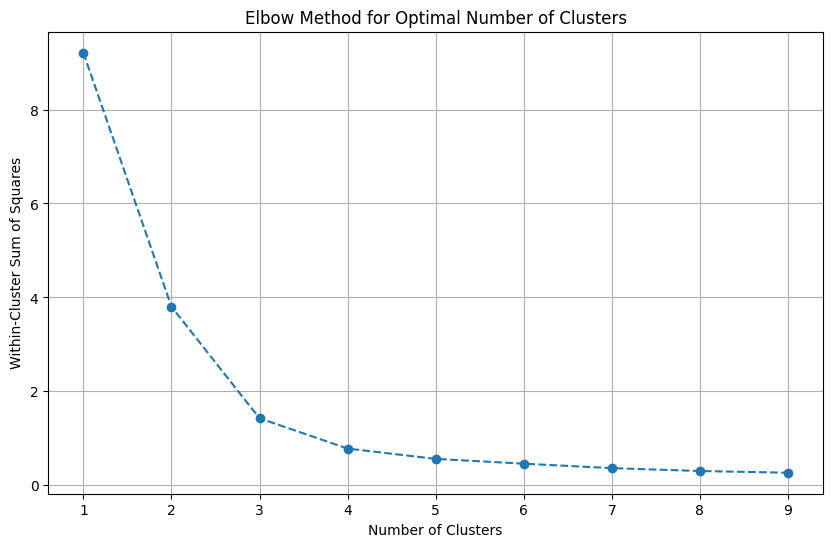

In [27]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Determine the optimal number of clusters using the Elbow method
wcss = []  # within-cluster sum of squares
cluster_range = range(1, 10)  # test up to 10 clusters

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, n_init=10, init="k-means++", random_state=42)
    kmeans.fit(vis_dims)
    wcss.append(kmeans.inertia_)

# Plot the Elbow method
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss, marker="o", linestyle="--")
plt.xlabel("Number of Clusters")
plt.ylabel("Within-Cluster Sum of Squares")
plt.title("Elbow Method for Optimal Number of Clusters")
plt.grid(True)
plt.show()

#### Slihouette method <a id="silhouette-method"></a>

For n_clusters = 2 The average silhouette_score is : 0.685228411941673
For n_clusters = 3 The average silhouette_score is : 0.6953100289652986
For n_clusters = 4 The average silhouette_score is : 0.5424746997805461
For n_clusters = 5 The average silhouette_score is : 0.4814149844488312
For n_clusters = 6 The average silhouette_score is : 0.4821791695455686


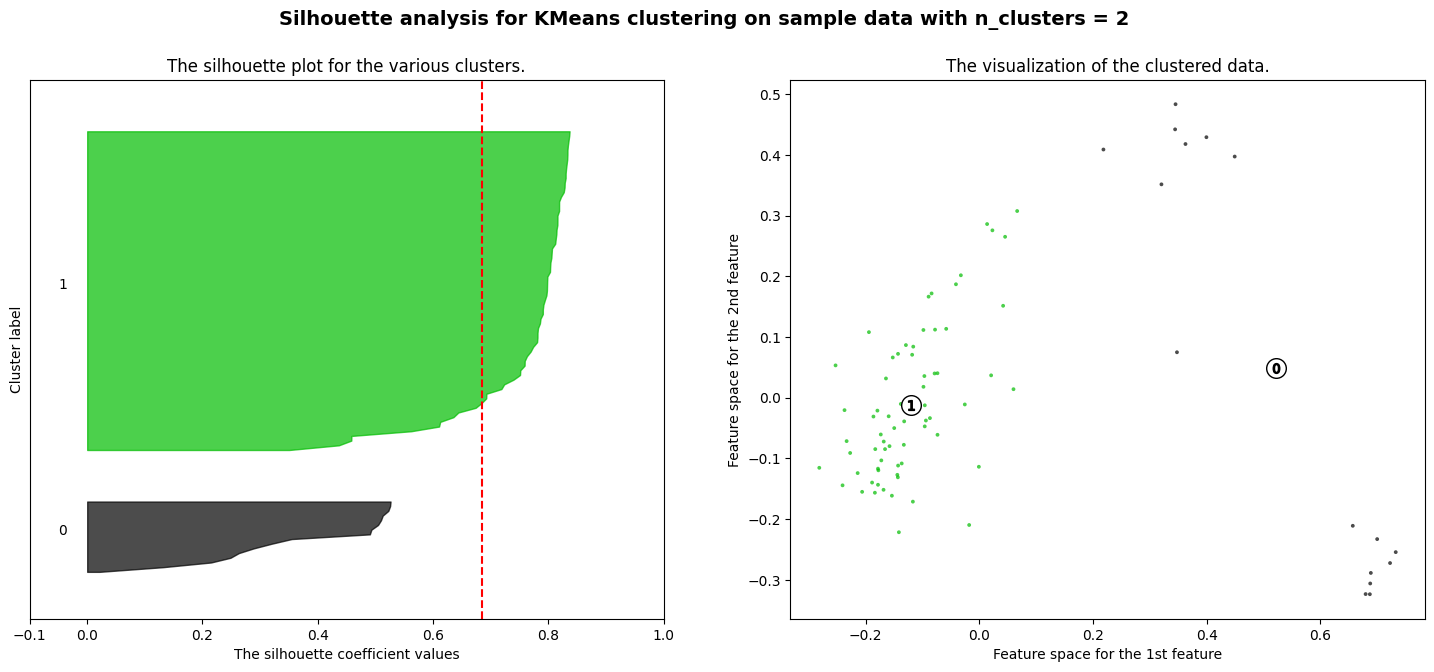

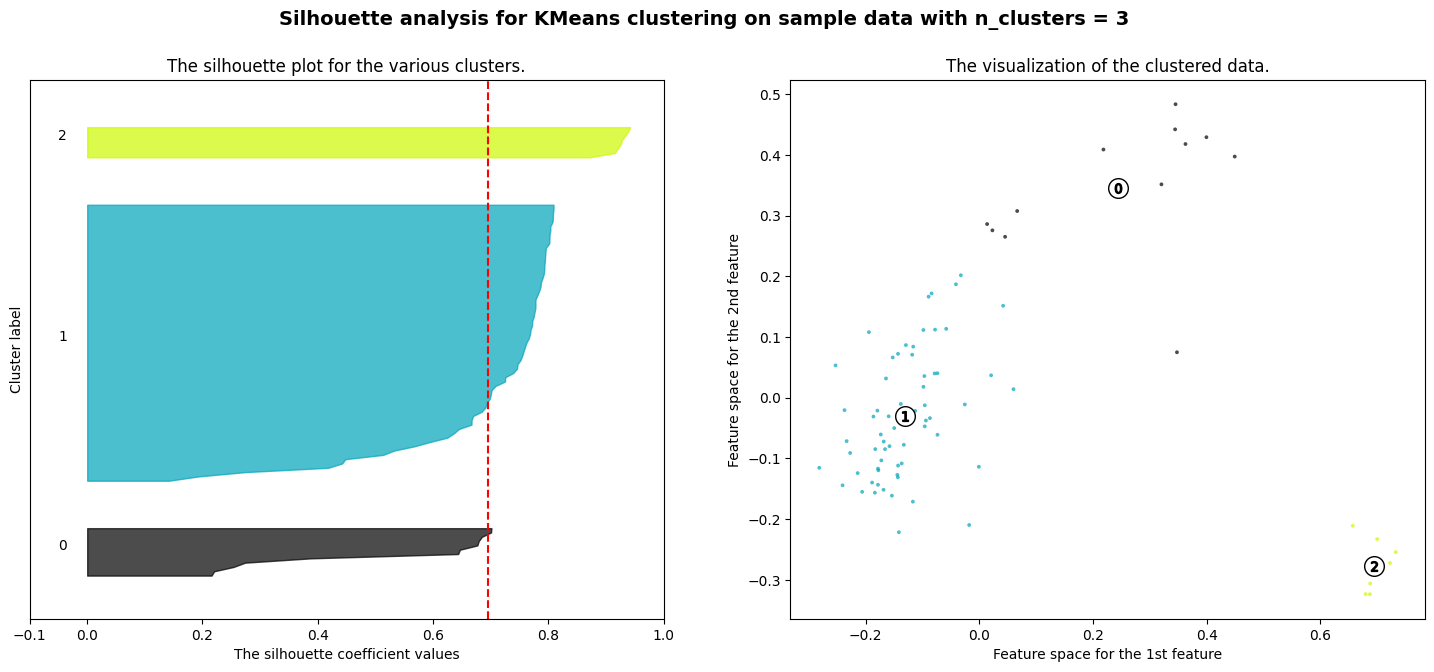

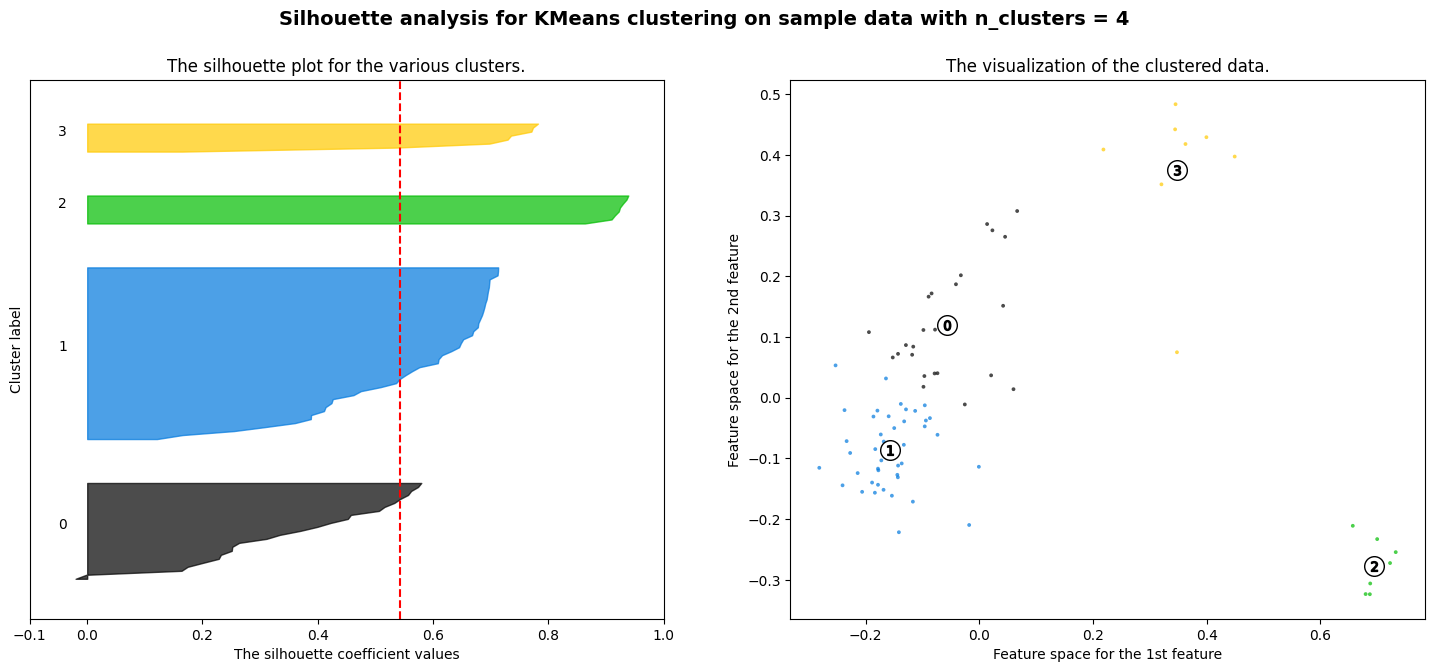

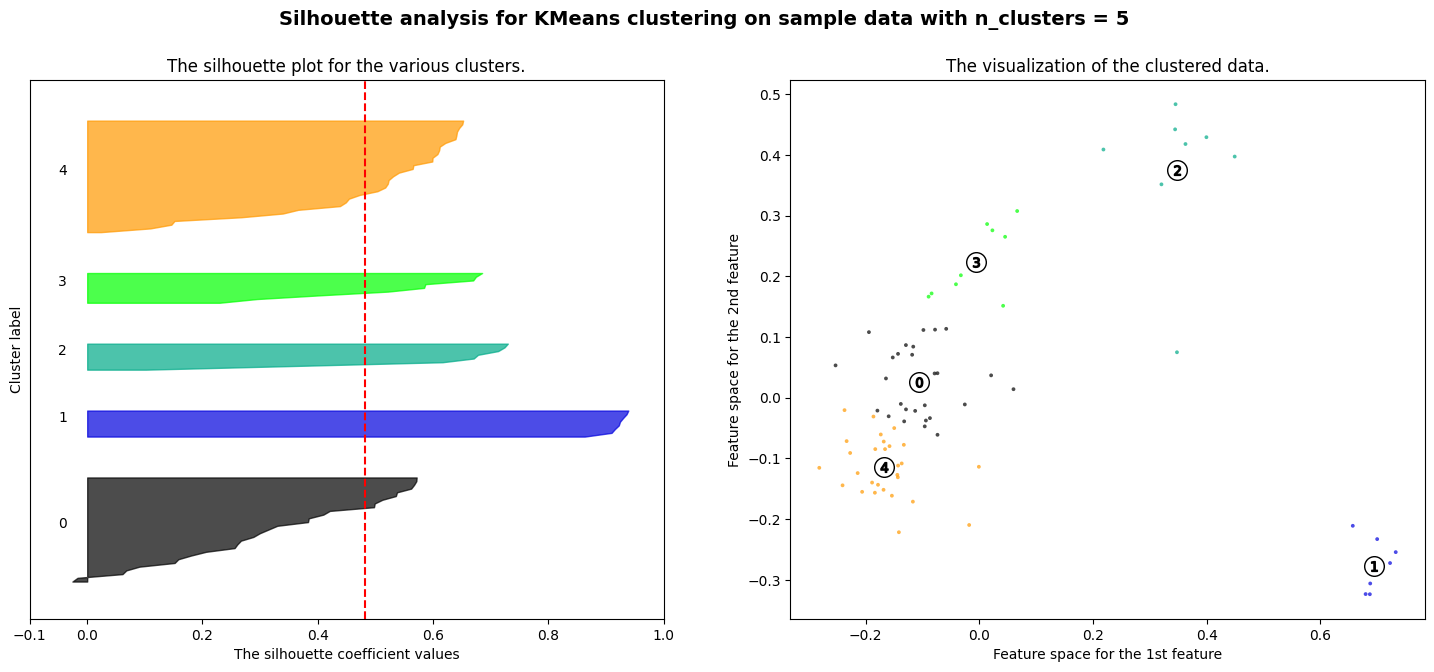

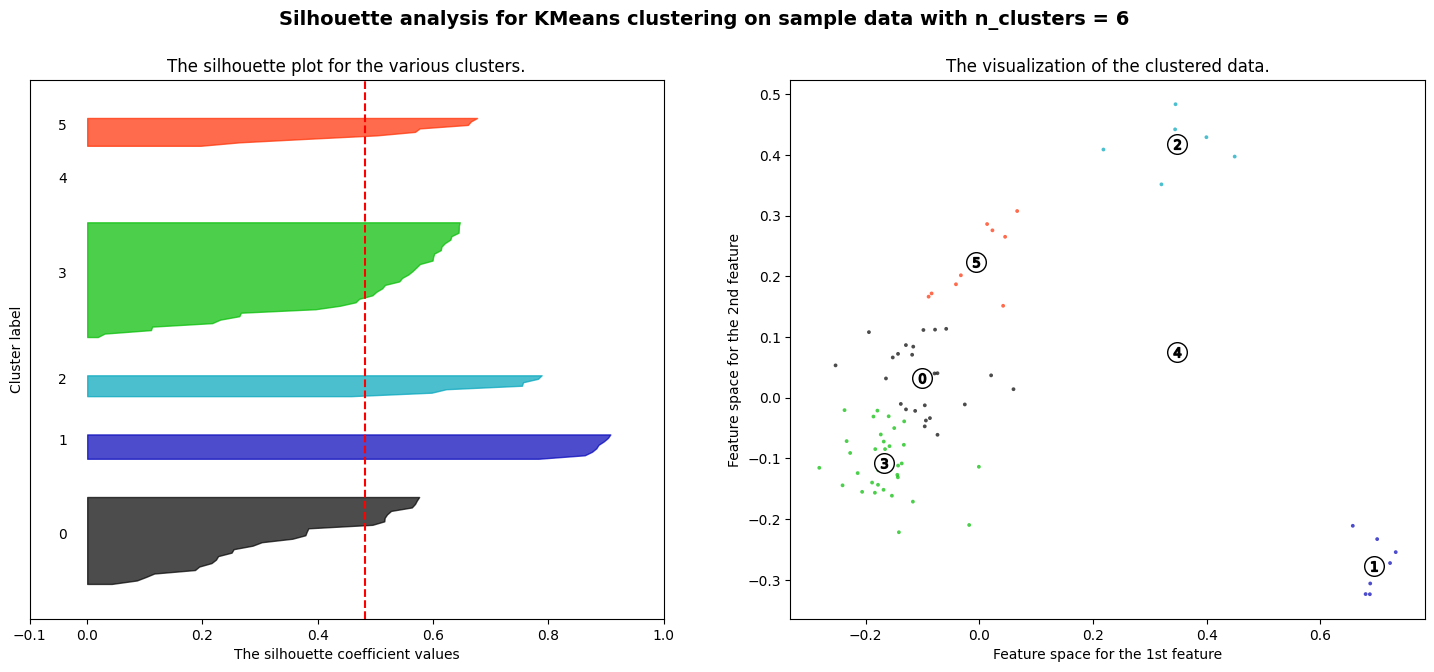

In [28]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score


range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(vis_dims) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(
        n_clusters=n_clusters, n_init=10, init="k-means++", random_state=42
    )
    cluster_labels = clusterer.fit_predict(vis_dims)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(vis_dims, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(vis_dims, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        vis_dims[:, 0],
        vis_dims[:, 1],
        marker=".",
        s=30,
        lw=0,
        alpha=0.7,
        c=colors,
        edgecolor="k",
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [29]:
n_clusters = 2  # we will pick 2 clusters -> positive, negative

kmeans = KMeans(n_clusters=n_clusters, n_init=10, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
sentiment_df["cluster"] = labels
sentiment_df

,index,document,n_tokens,embedding,cluster
0,3,"""us 500 futures discussions. hey guys what is ...",17,"[-0.0055852425284683704, 0.03172076866030693, ...",1
1,1029,jd ubs yijia niu o (52617) bonds and structure...,408,"[-0.016744792461395264, 0.0010663296561688185,...",0
2,9,"gold futures discussions. so, any more short p...",35,"[-0.03435482084751129, 0.0048997532576322556, ...",1
3,13,gold futures discussions. i read somewhere tha...,42,"[-0.0076690600253641605, 0.0014000566443428397...",1
4,18,ali ubs yijia niu d (52614) bonds and structur...,389,"[-0.01505182683467865, 0.0010738626588135958, ...",0
...,...,...,...,...,...
80,991,gold futures discussions. yes that's follo...,32,"[-0.006590832490473986, 0.009043603204190731, ...",1
81,993,silver futures discussions. buy physical. drai...,11,"[-0.030834078788757324, 0.011299445293843746, ...",1
82,1001,"gold futures discussions. nice $3 from $1766, ...",15,"[-0.05238998681306839, -0.0167976263910532, 0....",1
83,1015,gold futures discussions. have u sold ur past ...,11,"[0.002199979266151786, -0.041023869067430496, ...",1


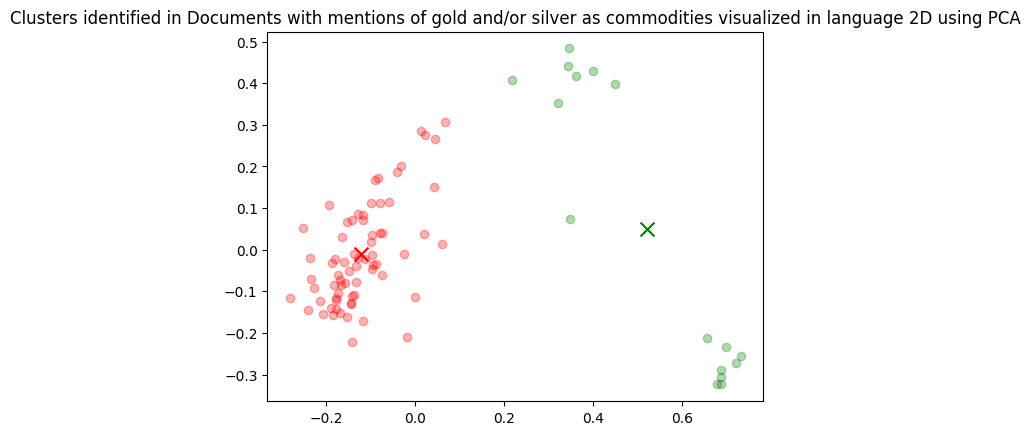

In [30]:
x = [x for x, _ in vis_dims]
y = [y for _, y in vis_dims]

for category, color in enumerate(["green", "red"]):
    xs = np.array(x)[sentiment_df.cluster == category]
    ys = np.array(y)[sentiment_df.cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)

plt.title(
    "Clusters identified in Documents with mentions of gold and/or silver as commodities visualized in language 2D using PCA"
)
plt.show()

### Conclusion on Explanatory Data Analysis (EDA) <a id="conclusion-on-explanatory-data-analysis-eda"></a>

It seems our cluster has picked out mainly long documents (i.e. articles) and short documents (i.e. tweets, headlines). This means embeddings of longer documents are more similar than shorter documents. While this isn't the exact goal we were trying to achieve, it is nice to know that the embeddings were able to capture this difference and that a simple dimensionality reduction with clustering could reveal such results.

**Note:** We have just realised that some documents are very long and that we can further tokenize them by sentences in individual documents. However, we will leave that improvement to the readers and not attempt to do so in this already extensive notebook.

In [31]:
sentiment_df[sentiment_df.cluster == 0].document.sample(2).to_list()  # long documents

['ali ubs yijia niu d (52614) bonds and structured products-[maturity announcement-cbbc]. ali ubs yijia niu d(52614) mandatory redemption event and early expiry notice of callable bull/bear contracts issued by swiss bank (93kb, pdf) report to today’s hong kong economic journal, dr. yuen kangjue | xinhealth ye yongkeng | wealth management international finance | today 04:44 important notice | yesterday 23:26 important notice | yesterday 23:29 important notice | yesterday 23:10 international finance | today 04:10 current affairs | today 00:36 important notice | yesterday 23:11 international finance | today 04:09 important notice | today 08:22 international finance | today 07:59 real-time news analysis and commentary today&#39;s letter series stock financial management real estate life/innovation technology subscription to the popular hong kong economic journal | terms of service | privacy policy | disclaimer | advertising inquiry | join the hong kong economic journal | futures index info

In [32]:
sentiment_df[sentiment_df.cluster == 1].document.sample(2).to_list()  # short documents

['silver futures discussions. convey my wishes to short employee for yesterday work',
 'gold futures discussions. hmm, still one way dive... ready to hedge']

## Step 3: Sentiment Analysis Model Selection

### Model Choice <a name="model-choice"></a>

There are several approaches we can attempt. Because we have a rather small dataset of only 85 documents where gold and/or silver were mentioned as commodities, we could theoretically label a portion of them. Then, we could use the labelled dataset to fine-tune a pre-trained model on a Sentiment Anlaysis task. Finally, we can use this fine-tuned sentiment analysis model to classify our remaining unlabelled dataset.

Another method is to use a Large Language Model (LLM). LLMs are pre-trained on extremely huge corpus of textual data. By pre-training LLMs with the Masked Language Modeling (MLM) objective for Next Word Prediction (NWP) task, LLMs were able to learn (or extract) the semantics from its large training corpus. In other words, other than being really good at the NWP task, LLMs are also able to discern between a positive review from a negative one. This is an emergent property of LLMs considering how they weren't directly trained on classifying if a review was positive or negative.

In this section, I will use an LLM to perform sentiment analysis. Let's just say I do not want to manually label my dataset 🙃.

In [33]:
# Reading a document which belong to each group.
doc_per_cluster = 5

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    documents = "\n".join(
        sentiment_df[sentiment_df.cluster == i]
        .document.sample(doc_per_cluster, random_state=42)
        .values
    )

    messages = [
        {
            "role": "user",
            "content": f'What do the following documents have in common? Please also indicate if the sentiment of the document is either `POSITIVE`, `NEGATIVE` or `NEUTRAL`.\n\Documents:\n"""\n{documents}\n"""\n\Answer:',
        }
    ]

    response = client.chat.completions.create(
        model="gpt-4",
        messages=messages,
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response.choices[0].message.content.replace("\n", ""))

    sample_cluster_rows = sentiment_df[sentiment_df.cluster == i].sample(
        doc_per_cluster, random_state=42
    )

    for j in range(doc_per_cluster):
        print(sample_cluster_rows.document.str[:70].values[j], end="\n\n")

    print("-" * 100)

Cluster 0 Theme: All the documents are related to financial news, updates, and announcements. They all contain information about investment products, economic events, and financial advice. The sentiment of all the documents is `NEUTRAL` as they are providing factual information without expressing any positive or negative opinions.
jd ubs yijia niu o (52617) bonds and structured products-[maturity ann

ali ubs yijia niu d (52614) bonds and structured products-[maturity an

european equities: it’s a busy economic calendar with gdp figures in f

zhejiang united investment (08366) change of registered address or off

simor ubs yijia niu e(53255) bonds and structured products-[maturity a

----------------------------------------------------------------------------------------------------
Cluster 1 Theme: All the documents are discussions about different types of futures, specifically precious metals like silver and gold, and US 500 futures. The sentiment of the documents is NEUTRAL as they 

## Finally: Challenges and Considerations <a id="finally-challenges-and-considerations-2"></a>

* **Performance:** For large documents, consider batching the sentences before submitting to the sentiment analysis pipeline for efficiency.

* **Time Sensitivity:** In financial sentiment analysis, timeliness is crucial. Ensure your pipeline can process data rapidly enough to be relevant.